In [1]:
!pip install pandas scikit-learn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from include.utils import incrementar_dados_aleatorios_csv, categorizar_imc, dados_especificos_coluna
from include.graficos import montar_graficos, montar_grafico_correlacao
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

**1. Definição do Problema de Negócios**

**Contexto do Problema:**

O contexto do problema é a construção de um modelo preditivo de regressão para prever os custos médicos individuais cobrados pelo seguro de saúde.
Isso envolve analisar um conjunto de dados que contém informações sobre características individuais, como idade, gênero, IMC (índice de massa corporal), número de filhos, fumante ou não, região, entre outros, e os custos médicos correspondentes.

**Objetivos da Análise:**

- Desenvolver um modelo preditivo de regressão que possa fazer previsões confiáveis dos custos médicos individuais com base nas características fornecidas.
- Avaliar a importância das diferentes características no modelo de previsão de custos médicos.
- Identificar padrões e relacionamentos nos dados que possam ajudar a melhorar a precisão das previsões.
- Fornecer insights para ajudar a entender os principais fatores que influenciam os custos médicos individuais.

**Perguntas de Negócios:**

- Quais características individuais têm maior impacto nos custos médicos cobrados pelo seguro de saúde?
- Existe alguma correlação entre certas características (por exemplo, idade, IMC) e os custos médicos?
- O número de filhos influencia significativamente nos custos médicos?
- Há uma diferença significativa nos custos médicos entre fumantes e não fumantes?
- Qual é o impacto da região de residência no custo médico individual?
- Como o modelo pode ser utilizado para prever e planejar os custos médicos futuros?

**Benefícios Esperados:**

- Melhor compreensão dos fatores que contribuem para os custos médicos individuais.
- Desenvolvimento de um modelo preditivo preciso que possa ser usado para prever custos médicos futuros com base em diferentes características individuais.
- Melhoria na precificação do seguro de saúde, permitindo uma cobrança mais precisa e justa dos prêmios.
- Potencial economia de custos para seguradoras e segurados, evitando subestimação ou superestimação dos custos médicos.

**Descrição dos dados disponíveis**
    
Os dados disponíveis consistem em um conjunto de informações sobre segurados de um plano de saúde. Cada entrada no conjunto de dados contém as seguintes características:

- **Idade (int):** A idade do segurado.
- **Gênero (string):** O gênero do segurado (masculino ou feminino).
- **IMC (float):** O índice de massa corporal do segurado.
- **Número de Filhos (int):** O número de filhos do segurado.
- **Fumante (string):** Indicação se o segurado é fumante ou não.
- **Região (string):** A região geográfica onde o segurado reside.
- **Encargos (float):** Os custos médicos individuais cobrados pelo seguro de saúde.

Durante o processamento, os dados são salvos em 4 planilhas (pasta planilhas):
- **1_dados_originais.csv:** Esta planilha representa um "pequeno universo" de dados. No caso alimentei apenas com os dados mencionados no Tech Challenge do site da FIAP
- **2_dados_aleatorios_sobre_original.csv:** Esta planilha é gerada já no início do código para alimentar mais dados da planilha original, incrementar no dataset original, e além disso seus dados foram embaralhados, com colunas com dados nan (pra serem tratados mais a frente)
- **3_dados_com_outliers.csv:** Esta planilha demostra os outliers para cada coluna
- **4_dados_futuros.csv:** Esta planilha é gerada para realizar previsões futuras, após escolha do melhor modelo

Esses dados serão utilizados para desenvolver um modelo preditivo de regressão para prever os custos médicos individuais com base nas características fornecidas. Para alcançar esse objetivo, a avaliação dos modelos será realizada com base em métricas como R² (coeficiente de determinação) e MAE (erro absoluto médio) para medir a acurácia dos modelos. A seleção do melhor modelo será feita com base na acurácia média com validação cruzada, e a otimização de hiperparâmetros será direcionada para maximizar a acurácia do modelo selecionado.

**2. Análise dos Dados**

**Sumário dos Dados:**

In [3]:
# leia os dados CSV indicados no site da FIAP
dados = pd.read_csv('../planilhas/1_dados_originais.csv', encoding='latin-1')

# aqui chamo a função incrementar_dados_aleatorios, para aumentar o volume da variável dados
dados = incrementar_dados_aleatorios_csv(dados)

# Aplicando a função para categorizar IMC e criar uma nova coluna 'Categoria_IMC'
dados['Categoria_IMC'] = dados['IMC'].apply(categorizar_imc)

# Criando mais uma coluna fumante_numero para usar mais pra frente na correlação
mapeamento_fumante = dados['Fumante'].map({'sim': 1, 'não': 0})

# Criar uma nova coluna 'Fumante_Numero' antes da coluna 'Encargos'
dados.insert(dados.columns.get_loc('Encargos'), 'Fumante_Numero', mapeamento_fumante)

print("\nLista de todas colunas:\n\n", list(dados))
print("\nAmostra dos dados:\n\n", dados.head())
print(f"\nQuantidade de linhas: {dados.shape[0]}. Quantidade de colunas: {dados.shape[1]}")
print("\nTipos de dados das colunas:\n\n", dados.dtypes)
print("\nQuantidade de valores ausentes por coluna:\n\n", dados.isnull().sum())


Lista de todas colunas:

 ['Idade', 'Gênero', 'IMC', 'Filhos', 'Fumante', 'Região', 'Fumante_Numero', 'Encargos', 'Categoria_IMC']

Amostra dos dados:

    Idade     Gênero    IMC  Filhos Fumante    Região  Fumante_Numero  \
0   56.0   feminino  29.77     2.0     sim  sudoeste             1.0   
1   46.0  masculino  25.86     1.0     não  nordeste             0.0   
2   32.0  masculino  23.01     0.0     não  sudoeste             0.0   
3   59.0  masculino    NaN     2.0     sim  noroeste             1.0   
4    NaN  masculino  30.15     NaN     não   sudeste             0.0   

   Encargos   Categoria_IMC  
0  31109.89       Sobrepeso  
1  26650.70       Sobrepeso  
2  21459.04     Peso normal  
3   6388.89  Valor Inválido  
4   1057.56           Obeso  

Quantidade de linhas: 2003. Quantidade de colunas: 9

Tipos de dados das colunas:

 Idade             float64
Gênero             object
IMC               float64
Filhos            float64
Fumante            object
Região            

**Visualização dos Dados:** gráficos para entender a distribuição e padrões nos dados.

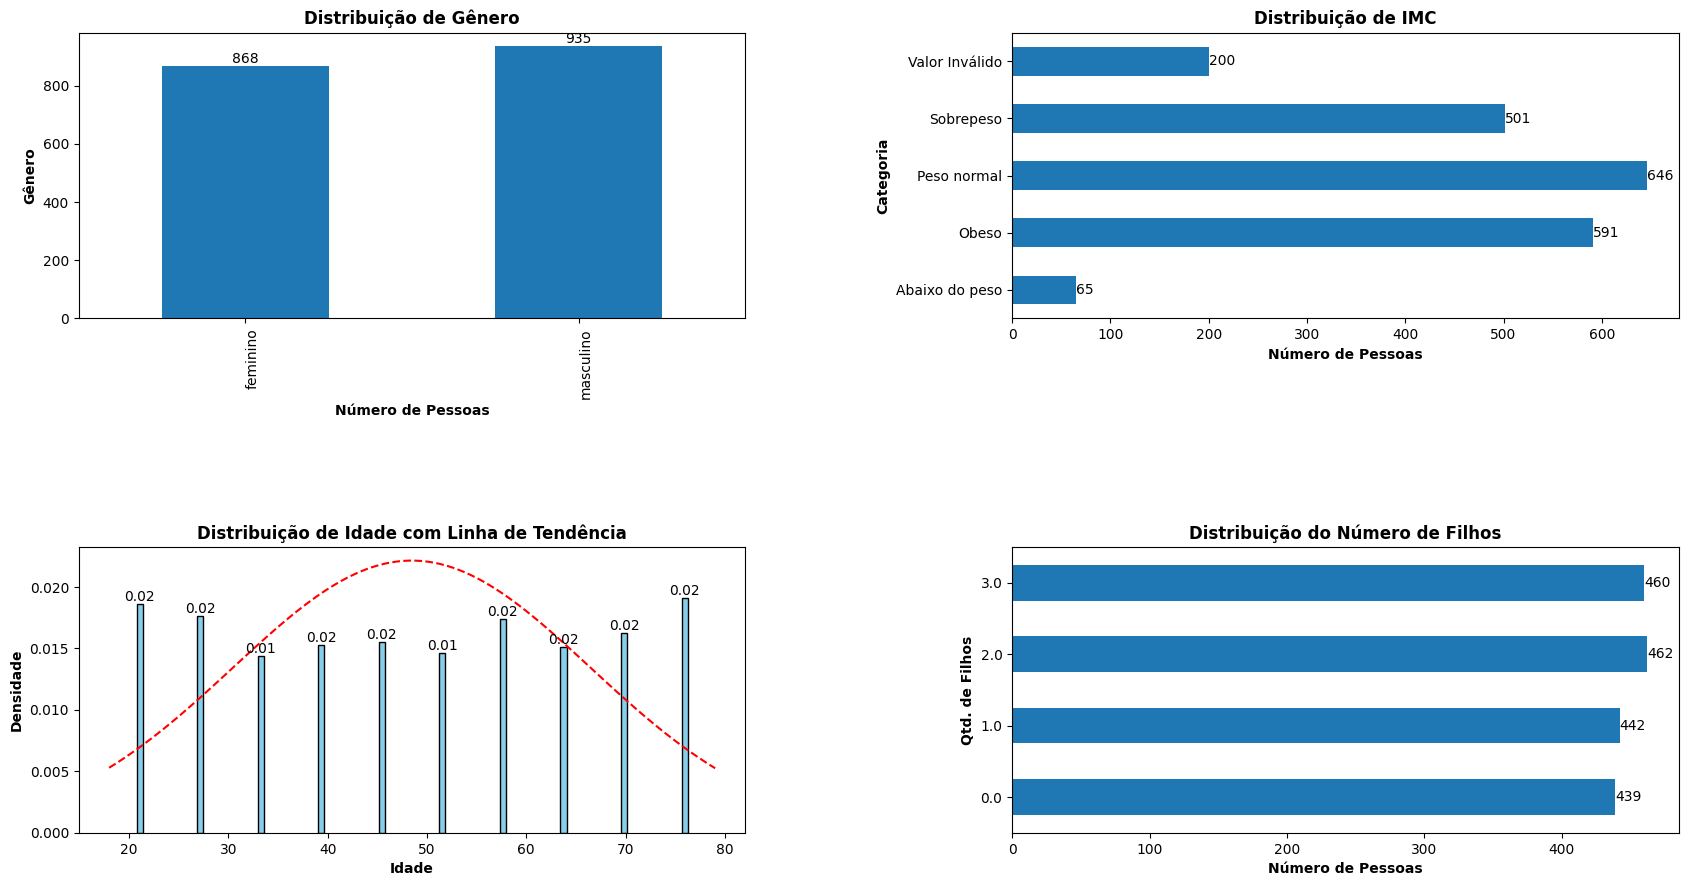

In [4]:
montar_graficos(dados)

**3. Separação dos Dados em Treino e Teste**

In [5]:
# Dividir os dados em features (X) e target (y)
X = dados.drop(['Encargos'], axis=1)  # descartando colunas não necessárias para o teste
y = dados['Encargos']

# Codificar variáveis categóricas usando one-hot encoding
colunas_codificadas_via_one_hot = ['Região']
encoder = OneHotEncoder(drop='first')
X_encoded = encoder.fit_transform(X[colunas_codificadas_via_one_hot])

# Concatenar features codificadas com as restantes
X_encoded = pd.DataFrame(X_encoded.toarray(), columns=encoder.get_feature_names_out(colunas_codificadas_via_one_hot), index=X.index)
X = pd.concat([X.drop(colunas_codificadas_via_one_hot, axis=1), X_encoded], axis=1)

# Codificar variáveis com LabelEncoder
label_encoder = LabelEncoder()
X['Categoria_IMC'] = label_encoder.fit_transform(X['Categoria_IMC'])
X['Gênero'] = label_encoder.fit_transform(X['Gênero'])
X['Fumante'] = label_encoder.fit_transform(X['Fumante'])

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

correlation_matrix = X_train.corr()
print('Visualizar a matriz de correlação:')
print(correlation_matrix)

Visualizar a matriz de correlação:
                    Idade    Gênero       IMC    Filhos   Fumante  \
Idade            1.000000  0.034662  0.018702  0.028879  0.025506   
Gênero           0.034662  1.000000  0.009623  0.006555 -0.024389   
IMC              0.018702  0.009623  1.000000 -0.021743  0.060565   
Filhos           0.028879  0.006555 -0.021743  1.000000 -0.014614   
Fumante          0.025506 -0.024389  0.060565 -0.014614  1.000000   
Fumante_Numero   0.039052 -0.023655  0.056944 -0.017046  1.000000   
Categoria_IMC   -0.047490  0.017772 -0.247846 -0.037571 -0.053819   
Região_noroeste -0.009017  0.032193  0.034500 -0.001945 -0.024538   
Região_sudeste  -0.032353 -0.014001 -0.005615 -0.052033  0.022100   
Região_sudoeste  0.019684 -0.017849 -0.012067  0.022362  0.045580   
Região_nan      -0.003630 -0.005351 -0.033411  0.038823 -0.031016   

                 Fumante_Numero  Categoria_IMC  Região_noroeste  \
Idade                  0.039052      -0.047490        -0.009017   
Gê

**4. Análise Exploratória de Dados**

**Resumo Estatístico:**

In [6]:
print("\nInformações adicionais sobre os dados:\n\n", dados.describe())

dados_especificos_coluna(dados, "Idade")
dados_especificos_coluna(dados, "IMC")
dados_especificos_coluna(dados, "Filhos")
dados_especificos_coluna(dados, "Encargos")


Informações adicionais sobre os dados:

              Idade          IMC       Filhos  Fumante_Numero      Encargos
count  1803.000000  1803.000000  1803.000000     1803.000000   2003.000000
mean     48.462562    26.708808     1.523017        0.508597   4785.204299
std      18.012793     4.995087     1.116866        0.500065   1722.208522
min      18.000000    18.000000     0.000000        0.000000    786.730000
25%      33.000000    22.445000     1.000000        0.000000   3716.165000
50%      49.000000    27.080000     2.000000        1.000000   4804.020000
75%      64.000000    30.990000     3.000000        1.000000   5922.035000
max      79.000000    34.990000     3.000000        1.000000  31109.890000

Na coluna Idade (float64) a faixa dos dados está entre: 18 até 79.
O valor mais frequente na coluna Idade é: 30, que aparece 44 vezes.

Na coluna IMC (float64) a faixa dos dados está entre: 18.0 até 34.99.
O valor mais frequente na coluna IMC é: 23.11, que aparece 6 vezes.

Na colu

<Axes: >

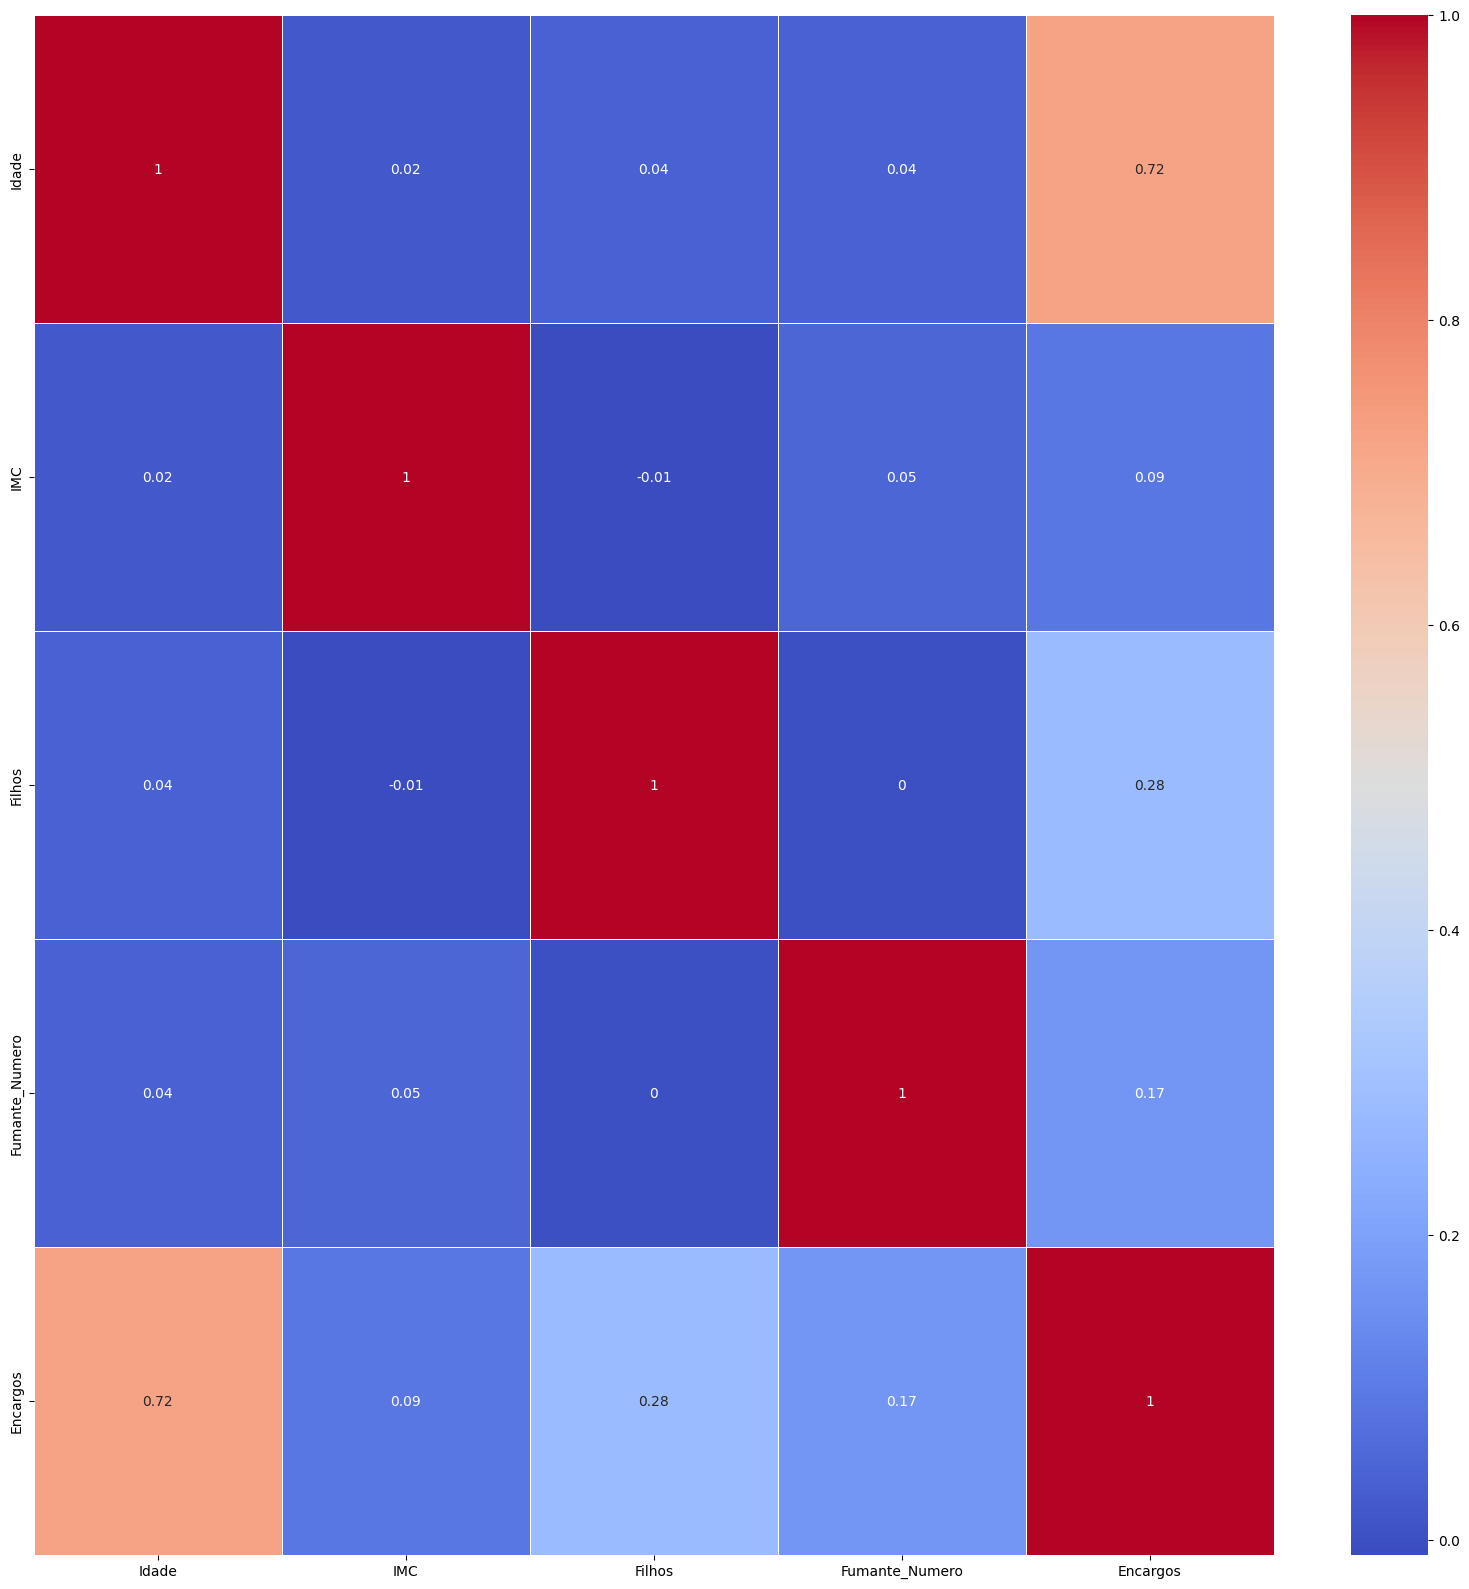

In [7]:
numeric_columns = dados.select_dtypes(include='number')

correlation_matrix = numeric_columns.corr().round(2)

fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax=ax, cmap="coolwarm")

**Identificação de Outliers:** 

<Axes: >

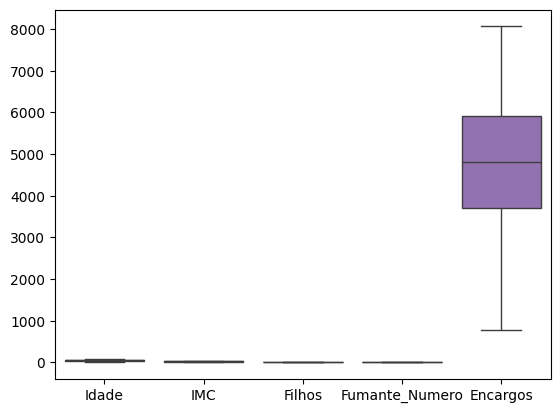

In [8]:
# Loop sobre as colunas
for coluna in dados.columns:
    # Quartis só funcionam em colunas numéricas
    if dados[coluna].dtype in ['int64', 'float64']:
        # Calcular os quartis para a coluna atual
        quartis = dados[coluna].quantile([0.25, 0.75])
        
        # Calcular o intervalo interquartil (IQR)
        iqr = quartis[0.75] - quartis[0.25]
        
        # Definir limites para identificar outliers
        limite_inferior = quartis[0.25] - 1.5 * iqr
        limite_superior = quartis[0.75] + 1.5 * iqr
        
        # Marcar os outliers como NaN
        dados['outlier_mask_' + coluna] = ((dados[coluna] < limite_inferior) | (dados[coluna] > limite_superior)).astype(int)
        dados[coluna] = dados[coluna].mask(dados['outlier_mask_' + coluna] == 1)

# Salvar os dados com os outliers
dados.to_csv("../planilhas/3_dados_com_outliers.csv", index=False, encoding='latin1')
        
# Remover colunas de máscara de outliers
dados.drop(columns=[col for col in dados.columns if 'outlier_mask_' in col], inplace=True)

# Plotar boxplot
sns.boxplot(data=dados)

**Visualizações Gráficas:** Visualizações gráficas para entender a distribuição e relacionamentos entre as variáveis

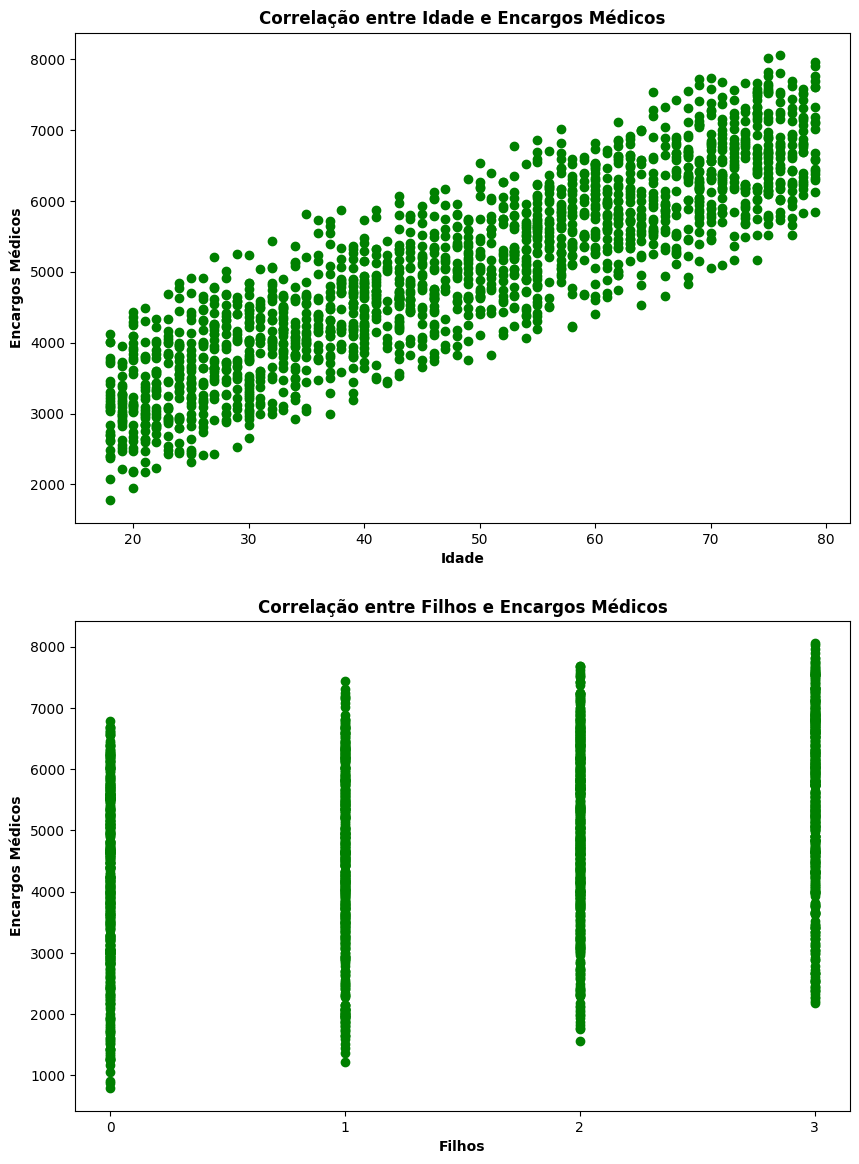

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(10, 14))

montar_grafico_correlacao(dados['Idade'], dados['Encargos'], axs[0],
                          'Correlação entre Idade e Encargos Médicos', 'Idade', 'Encargos Médicos')

montar_grafico_correlacao(dados['Filhos'], dados['Encargos'], axs[1],
                          'Correlação entre Filhos e Encargos Médicos', 'Filhos', 'Encargos Médicos')

plt.show()